**Cale Kochenour** \
GEOG 489 Spring 2020 \
March 15, 2020

# Extracting and Analyzing GPX Data from the Mansfield Double Up

## 1.0 Problem

This analysis attempts to answer the following questions: What is the nature of metrics for a runner in the Mansfield Double Up, and how do these metrics vary throughout the race? 

## 2.0 Background

The [Mansfield Double Up](http://www.nativeendurance.com/mansfielddoubleup.html) is a trail/mountain race in Stowe, Vermont, hosted by [Native Endurance](http://www.nativeendurance.com/). This race covers ~11 miles and ~5,000 feet of elevation gain/loss. The "Double Up" is a very appropriate name; the race starts and finishes at the same point and ascends Mount Mansfield (Vermont's highest mountain) from both the East and West sides throughout the race. In addition, runners are almost always running up or down, and very little of the course covers flat terrain.

I have had the privilege of running this race from the inaugural year in 2016 through 2018. Beyond understanding the qualitative physical effort required complete the race, I am intrigued about what insights GPX data can offer about the quantitative nature of the course. 

The GPX file analyzed in the project was provided by [Native Endurance](http://www.nativeendurance.com/), and it contains data from a runner who completed the race in 2017. Understanding what physical metrics are captured in this data and how they vary throughout the race provides a quantitative look at the race, beyond just the latitude, longitude, and overall time the runner took to complete the race.

## 3.0 Assumptions

This analysis assumes the GPX data is accurate, and any uncertainties form this data will be carried throughout the analysis. In addition, no data was changed or omitted from the analysis; the project analyzes the raw data.

## 4.0 Techniques and Tools

### 4.1 Techniques

The workflow uses the following techniques to solve the problem:

* Extract GPX data;
* Process GPX data;
* Visualize GPX data; and,
* Upload data to ArcGIS Online.

### 4.2 Tools

The analysis uses the following packages and classes, as imported in Section 5.1:

* *os*
* *sys*
* *re*
* *datetime*
* *matplotlib.pyplot*
* *matplotlib.dates*
* *pandas*
* *pandas.plotting*
* *geopandas*
* *gpxpy*
* *arcgis*
* *arcgis.gis*

## 5.0 Solution

### 5.1 Package Imports

This section imports all packages and classes that are necessary to run the notebook and complete the analysis.

In [1]:
# Standard library imports
import os
import sys
import re
from datetime import datetime

# Commonly used packages
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
from pandas.plotting import register_matplotlib_converters

# Third party imports
import geopandas as gpd
import gpxpy
import arcgis
from arcgis.gis import GIS

### 5.2 Function Definitions

This section defines functions that allow for extracting GPX data and uploading files to ArcGIS Online (AGOL).

In [2]:
def extract_gpx_data(gpx_file_path, attribute='elevation'):
    """Reads in a GPX file and returns a list of values
    for a specified GPX attribute.
    
    Parameters
    ----------
    gpx_file_path : str
        File path to the GPX file (.gpx extension).
        
    attribute: str
        Name of the attribute to extract. Default
        value is 'elevation'. Must match one of the
        entries in the function-defined list.
    
    Returns
    -------
    data : list
        List containing float values of the extracted
        GPX attributes.
    """   
    # Open GPX file in context manager and parse with gpxpy
    with open(gpx_file_path) as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    # Define GPX main attributes
    primary_attributes = [
        "latitude", 
        "longitude",
        "elevation",
        "time"   
    ]
    
    # Define GPX extension attributes
    secondary_attributes = [
        "cadence", "distance", "altitude",
        "energy", "speed", "verticalSpeed"
    ]
    
    # Check if specified attribute is in main 
    #  GPX attributes (lat/lon/elevation/time)
    if attribute in primary_attributes: 
            
        # Create list of values for attribute
        data = [{
            "latitude": point.latitude, 
            "longitude": point.longitude, 
            "elevation": point.elevation, 
            "time": point.time
            }.get(attribute)
            for track in gpx.tracks
            for segment in track.segments
            for point in segment.points
        ]
            
        print(f"SUCCESS: Added {attribute} data to dictionary.")
        
    # Check if specified attribute is in
    #  GPX extensions (cadence/distance/altitude
    #  /energy/speed/verticalSpeed)
    elif attribute in secondary_attributes:

        # Define pattern for attribute to match on
        pattern = re.compile(f"^.*{attribute}.*$")

        # Create list of values for attribute
        data = [
            float(extension.text) 
            for track in gpx.tracks 
            for segment in track.segments 
            for point in segment.points 
            for extension in point.extensions 
            if pattern.match(extension.tag)
        ]
        
        print(f"SUCCESS: Added {attribute} data to dictionary.")
        
    else:   
        data = []
        print("Invalid attribute. Must be one of the following: "
              "latitude, longitude, elevation, time, cadence "
              "distance, altitude, energy, speed, verticalSpeed.")
            
    # List of attribute values
    return data

In [3]:
# CODE FROM LESSON 3 WALKTHROUGH - Syntax modified slightly
# Search for content in your gis with a query built 
#  from title, owner, and item type
def search_agol(title, owner, item_type):
    return gis.content.search(query='title:'+title+' owner:'+owner, 
                              item_type=item_type)

In [4]:
# CODE FROM LESSON 3 WALKTHROUGH - Syntax modified slightly
# Test whether items exist on AGOL for given title, 
#  owner, and item type and if so, delete them from AGOL
def delete_if_exists_on_agol(title, owner, item_type):
    # Search item
    result = search_agol(title, owner, item_type)   
    print('Found items for title='+title+', owner='+owner+', itemType='+item_type+':')
    print(result)
    
    # Delete items found
    for item in result:                           
        item.delete()
        print('Item ' + item.title + ' has been deleted.')

### 5.3 Environment Setup/User Input

This section contains all of the variables that can be configured to fit a different user's computer and operating system. These variables include the working directory, paths to the GPX file, course zip file, and course shapefile, and the AGOL user name. In addition, a user can change the environmental variables for ArcGIS Pro authentication.

In [5]:
# Define and set working directory
working_directory = os.path.join(
    "C:\\", "PSU", "03-geog489-advanced-python-programming-gis", 
    "lesson-05", "07-git-repo", "02-raw-data")

os.chdir(working_directory)

# Define relative path to GPX file, shapefile, and zip file
double_up_gpx_path = "mansfield-double-up-course.gpx"
double_up_zip_path = "mount_mansfield_double_up_course.zip"
double_up_shp_path = "mount_mansfield_double_up_course.shp"

# Set environmental variables for ArcGIS Pro authentication
os.environ["PATH"] = r"{};{}".format(os.environ["PATH"], r"C:\Program Files\ArcGIS\Pro\bin")
sys.path.append(r"C:\Program Files\ArcGIS\Pro\Resources\ArcPy")

# Set ArcGIS Pro user name
username_agol = 'cxk525_pennstate'    

In [6]:
# Datetime converters; matplotlib/pandas
register_matplotlib_converters()

### 5.4 GPX Data Extraction

This section extracts the GPX data to a *pandas* dataframe. The attribute list defined in the section includes all attributes found in the GPX file. For other GPX files with additional data, the list could be modified to accommodate. The *extract_gpx_data* function would also have to be modified to accommodate, as this workflow defined the function to fit the Mansfield Double Up GPX file.

In [7]:
# Define list of GPX attributes
attribute_list = [
    "latitude", "longitude", "elevation", "time",
    "cadence", "distance", "altitude", "energy", 
    "speed", "verticalSpeed"
]

# Create dataframe from dictionary of gpx data
double_up_gpx_df = pd.DataFrame({
    attribute: extract_gpx_data(double_up_gpx_path, attribute)
    for attribute in attribute_list
})

SUCCESS: Added latitude data to dictionary.
SUCCESS: Added longitude data to dictionary.
SUCCESS: Added elevation data to dictionary.
SUCCESS: Added time data to dictionary.
SUCCESS: Added cadence data to dictionary.
SUCCESS: Added distance data to dictionary.
SUCCESS: Added altitude data to dictionary.
SUCCESS: Added energy data to dictionary.
SUCCESS: Added speed data to dictionary.
SUCCESS: Added verticalSpeed data to dictionary.


In [8]:
# Optional; view dataframe of raw GPX data
##double_up_gpx_df

### 5.5 GPX Data Processing

This section creates a copy of the dataframe from the previous section in order to make changes to the representation of the data. No data points were changed or omitted. The following list identifies the changes made to the representation of the data so that it could be interpreted further and plotted:

* Added elevation in feet (default elevation in meters);
* Converted *datetime* objects to a plottable format;
* Changed the hour in the *datetime* to reflect US Eastern time (timezone of the race);
* Added distance in miles (default distance in meters);
* Removed the altitude attribute (duplicate of elevation attribute);
* Normalized the energy so that the maximum value was set to 1 (original units unknown);
* Added speed in miles per hour; and,
* Added vertical speed in feet per second.

The workflow creates two additional dataframes, containing data points where the runner was running up and running down, respectively. These were created to plot the attributes over time while also visually encoding the data with the runner's vertical speed, to show which parts of the race the runner was ascending and descending the mountain.

The workflow also creates a geodataframe with *geopandas* in order to plot the course route and show how the GPX attributes vary throughout the course.

In [9]:
# Create copy of dataframe to modify/enhance
double_up_df_enhance = double_up_gpx_df.copy()

# Add elevation in feet
double_up_df_enhance["elevation_ft"] = double_up_df_enhance.elevation.apply(
    lambda x: x * 3.28084)

# Convert dateime object to plottable format (remove timezone)
double_up_df_enhance.time = double_up_df_enhance.time.apply(
    lambda x: datetime.strptime(str(x).replace('+00:00', ''), '%Y-%m-%d %H:%M:%S'))

# Change time to US Eastern, subtract 4 from timestamp hour
double_up_df_enhance.time = double_up_df_enhance.time.apply(
    lambda x: x.replace(hour=x.hour-4))

# Add distance in miles
double_up_df_enhance["distance_mile"] = double_up_df_enhance.distance.apply(
    lambda x: x / 1609.344)

# Drop altitude column (copy of elevation)
double_up_df_enhance.drop(columns='altitude', inplace=True)

# Normalize energy (units unknown)
double_up_df_enhance["energy_norm"] = double_up_df_enhance.energy.apply(
    lambda x: x / double_up_df_enhance.energy.max())

# Add speed in miles per hour
double_up_df_enhance["speed_mph"] = double_up_df_enhance.speed.apply(
    lambda x: x * 2.236936)

# Add vertical speed in ft/second
double_up_df_enhance["vertical_speed_ft_per_sec"] = double_up_df_enhance.verticalSpeed.apply(
    lambda x: x * 3.28084)

In [10]:
# Optional; view modified dataframe
##double_up_df_enhance

In [11]:
# Create dataframes for UP (vertical speed >= 0) 
#  and DOWN (vertical speed < 0); for plotting purposes
vertical_up_df = double_up_df_enhance[
    double_up_df_enhance.vertical_speed_ft_per_sec >= 0]

vertical_down_df = double_up_df_enhance[
    double_up_df_enhance.vertical_speed_ft_per_sec < 0]

In [12]:
# Optional; view up/down dataframes
##vertical_up_df 
##vertical_down_df 

In [13]:
# Create geodataframe from dataframe
crs = {'init': 'epsg:4326'}
double_up_gdf = gpd.GeoDataFrame(
    double_up_df_enhance, 
    geometry=gpd.points_from_xy(
        double_up_df_enhance.longitude, 
        double_up_df_enhance.latitude)
)

# Drop latitude/longitude (redundant with geometry)
double_up_gdf.drop(columns=["latitude", "longitude"], inplace=True)

In [14]:
# Optional; view geodataframe
##double_up_gdf

### 5.6 GPX Data Visualization

This section creates visualizations for the GPX data over time and throughout the course.

#### 5.6.1 Data Attribute Plots

This section plots the raw data (cadence, distance, energy, speed, vertical speed, elevation) over time, to see how each varies as the runner completes the course. The first plot contains subplots for all six attributes and how they vary throughout the course. The following four plots show cadence, energy, distance, and speed, and are visually encoded with the runner's vertical speed (ascending or descending).

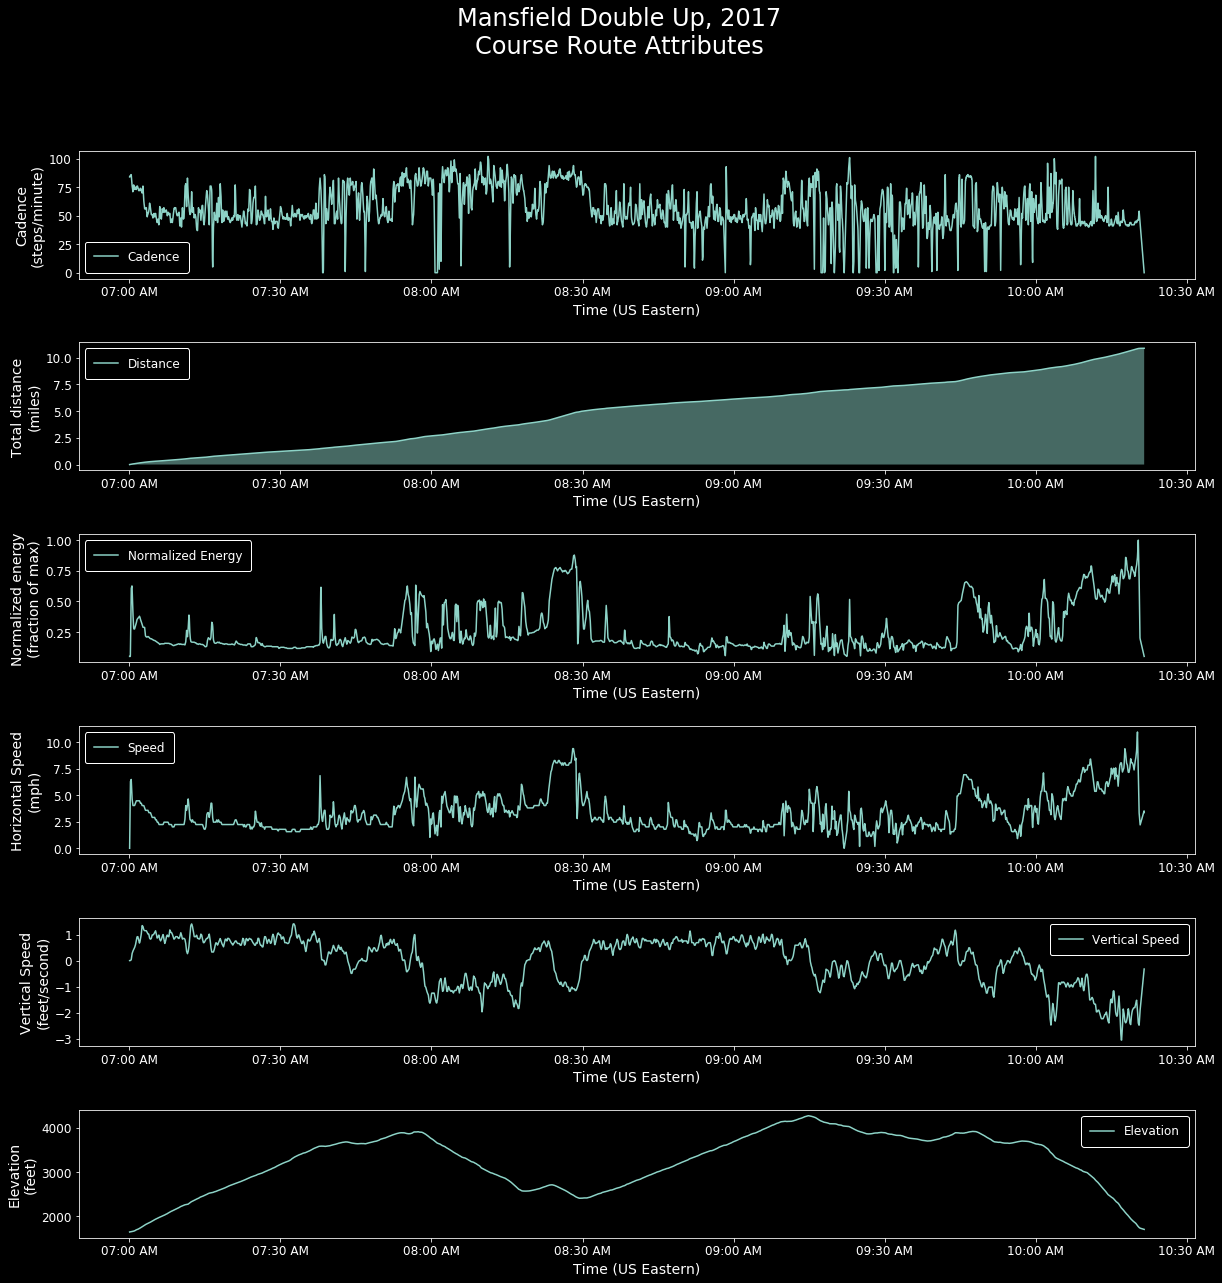

In [15]:
# Plot all raw data attributes over time
with plt.style.context('dark_background'): 

    fig, ax = plt.subplots(6, 1, figsize=(20, 20))
    
    plt.suptitle("Mansfield Double Up, 2017\nCourse Route Attributes", size=24)
    
    plt.subplots_adjust(hspace=0.5)

    ax[0].plot(
        double_up_df_enhance.time, double_up_df_enhance.cadence,
        label='Cadence', lw=1.5)

    ax[1].plot(
        double_up_df_enhance.time, double_up_df_enhance.distance_mile,
        label='Distance', lw=1.5)
    ax[1].fill_between(
        double_up_df_enhance.time, double_up_df_enhance.distance_mile, alpha=0.5)

    ax[2].plot(
        double_up_df_enhance.time, double_up_df_enhance.energy_norm,
        label='Normalized Energy', lw=1.5)

    ax[3].plot(
        double_up_df_enhance.time, double_up_df_enhance.speed_mph,
        label='Speed', lw=1.5)

    ax[4].plot(
        double_up_df_enhance.time, double_up_df_enhance.vertical_speed_ft_per_sec,
        label='Vertical Speed', lw=1.5, zorder=2)

    ax[5].plot(double_up_df_enhance.time, double_up_df_enhance.elevation_ft,
               label='Elevation', lw=1.5)
   
    # Define the date format
    date_form = DateFormatter("%H:%M AM")
   
    ax[0].set_ylabel("Cadence\n(steps/minute)")
    ax[1].set_ylabel("Total distance\n(miles)")
    ax[2].set_ylabel("Normalized energy\n(fraction of max)")
    ax[3].set_ylabel("Horizontal Speed\n(mph)")
    ax[4].set_ylabel("Vertical Speed\n(feet/second)")
    ax[5].set_ylabel("Elevation\n(feet)")
    
    for axes in ax:
        axes.xaxis.set_major_formatter(date_form)
        axes.legend(loc='best', 
                    borderpad=0.75,
                    edgecolor='white',
                    fontsize=12,
                    shadow=True)
        axes.xaxis.label.set_size(14)
        axes.yaxis.label.set_size(14)
        axes.title.set_size(24)
        axes.tick_params(labelsize=12)
        axes.set_xlabel("Time (US Eastern)")

    plt.show()

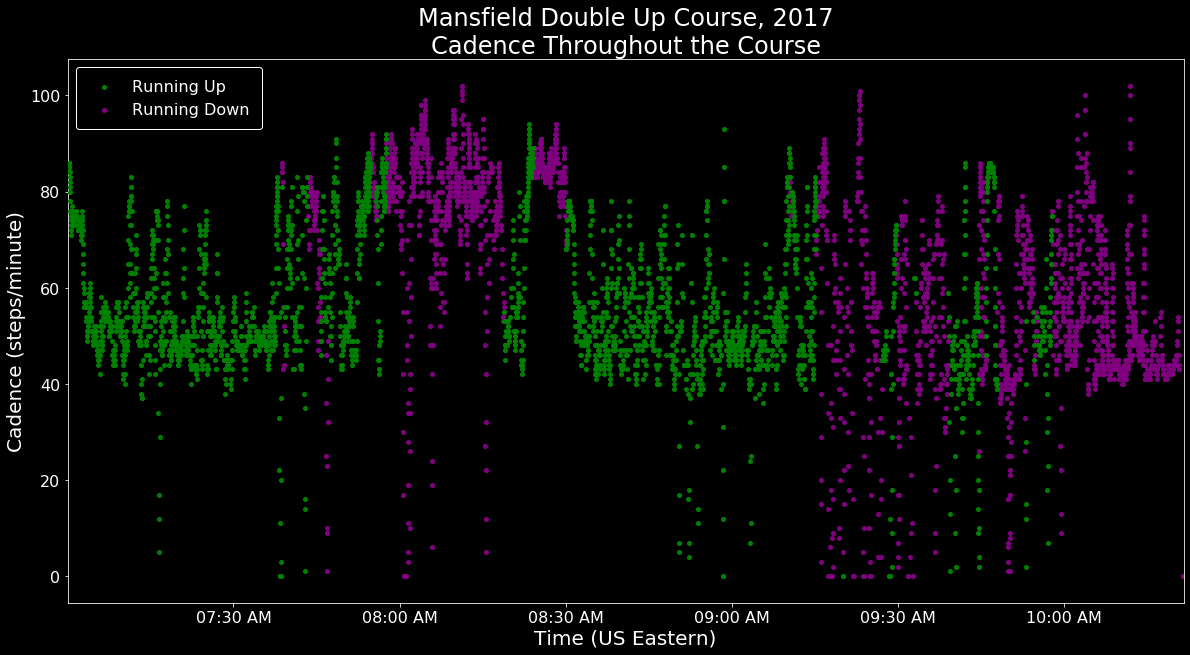

In [16]:
# Plot cadence, distinguishing up/down movement
with plt.style.context('dark_background'):
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    ax.scatter(
        vertical_up_df.time, vertical_up_df.cadence, color='green',
        label='Running Up', zorder=3, s=16)#, linewidth=2)
    
    ax.scatter(
        vertical_down_df.time, vertical_down_df.cadence, color='purple', 
        label='Running Down', zorder=2, s=16)

    plt.xlim(double_up_df_enhance.time.min(), double_up_df_enhance.time.max())

    ax.set_xlabel("Time (US Eastern)")
    ax.set_ylabel("Cadence (steps/minute)")
    ax.set_title("Mansfield Double Up Course, 2017\nCadence Throughout the Course", size=20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(24)
    ax.tick_params(labelsize=16)

    ax.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    # Define the date format
    date_form = DateFormatter("%H:%M AM")
    ax.xaxis.set_major_formatter(date_form)

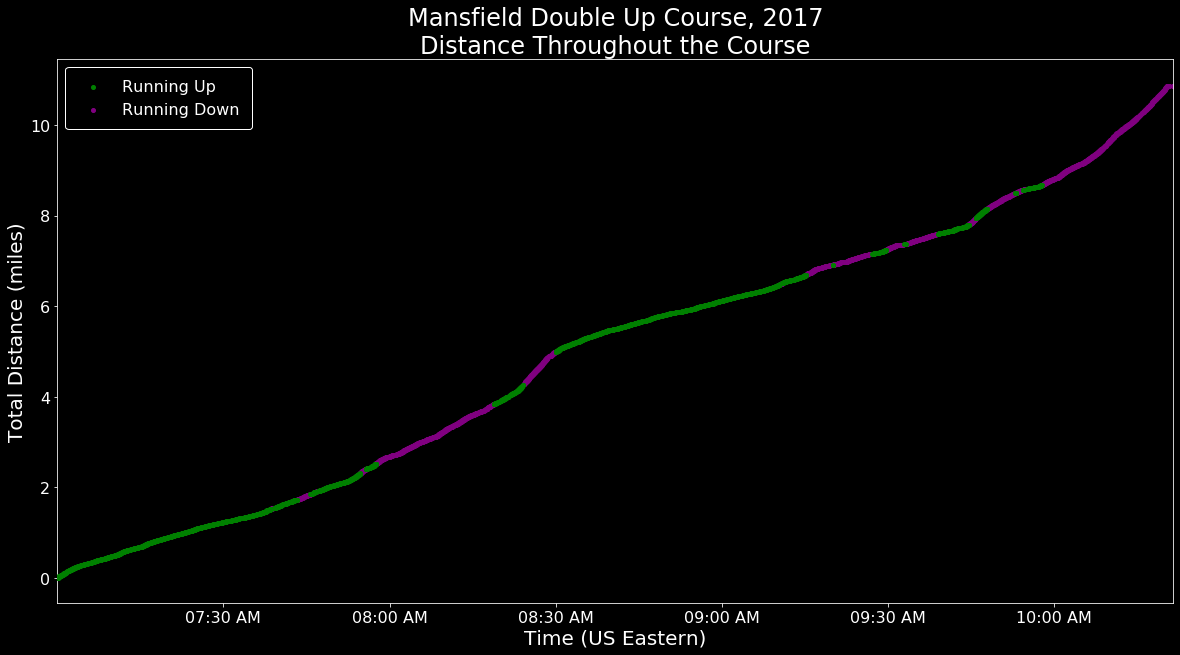

In [17]:
# Plot accumulated distance, distinguishing up/down movement
with plt.style.context('dark_background'):
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    ax.scatter(
        vertical_up_df.time, vertical_up_df.distance_mile, color='green',
        label='Running Up', zorder=3, s=16)
    
    ax.scatter(
        vertical_down_df.time, vertical_down_df.distance_mile, color='purple', 
        label='Running Down', zorder=2, s=16)

    plt.xlim(double_up_df_enhance.time.min(), double_up_df_enhance.time.max())
    
    ax.set_xlabel("Time (US Eastern)")
    ax.set_ylabel("Total Distance (miles)")
    ax.set_title("Mansfield Double Up Course, 2017\nDistance Throughout the Course", size=20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(24)
    ax.tick_params(labelsize=16)

    ax.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    # Define the date format
    date_form = DateFormatter("%H:%M AM")
    ax.xaxis.set_major_formatter(date_form)

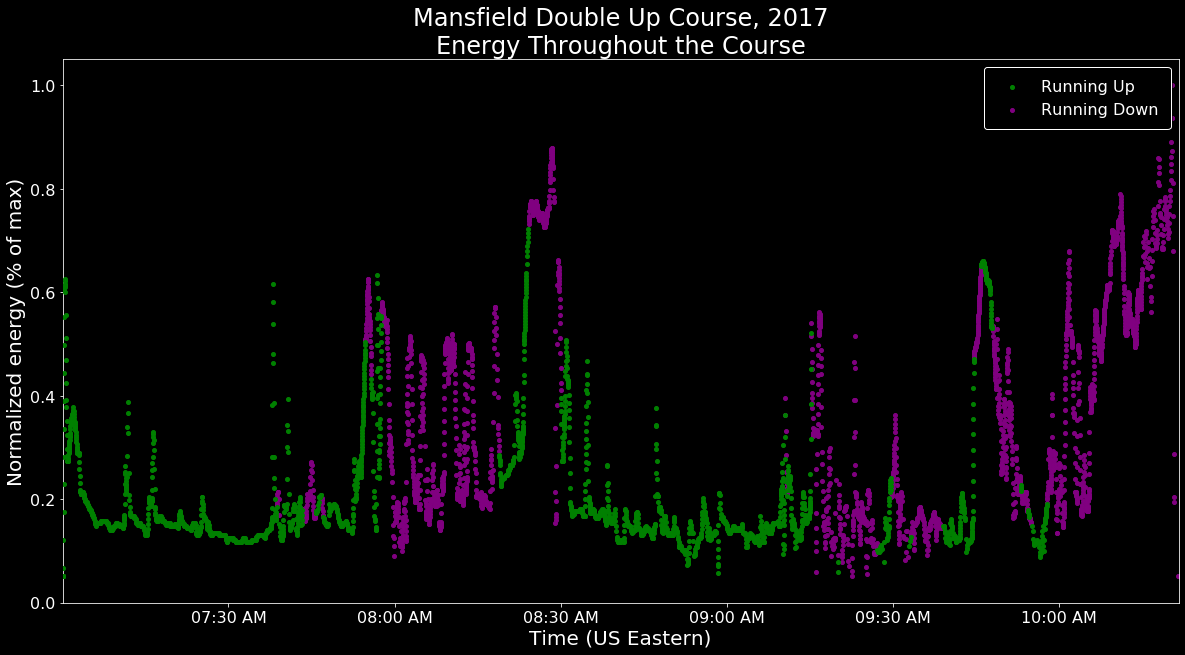

In [18]:
# Plot normalized energry, distinguishing up/down movement
with plt.style.context('dark_background'):
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    ax.scatter(
        vertical_up_df.time, vertical_up_df.energy_norm, color='green',
        label='Running Up', zorder=3, s=16)#, linewidth=2)
    
    ax.scatter(
        vertical_down_df.time, vertical_down_df.energy_norm, color='purple', 
        label='Running Down', zorder=2, s=16)

    plt.xlim(double_up_df_enhance.time.min(), double_up_df_enhance.time.max())
    
    ax.set_xlabel("Time (US Eastern)")
    ax.set_ylabel("Normalized energy (% of max)")
    ax.set_title("Mansfield Double Up Course, 2017\nEnergy Throughout the Course", size=20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(24)
    ax.tick_params(labelsize=16)

    ax.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    # Define the date format
    date_form = DateFormatter("%H:%M AM")
    ax.xaxis.set_major_formatter(date_form)

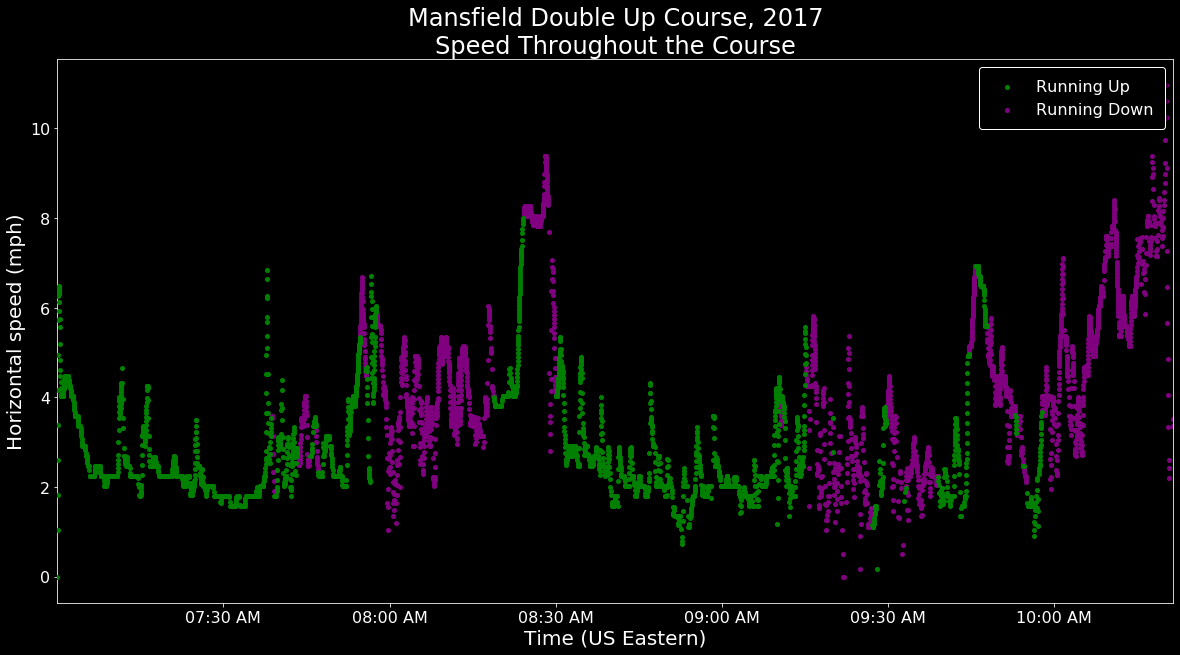

In [19]:
# Plot horizontal speed, distinguishing up/down movement
with plt.style.context('dark_background'):
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    ax.scatter(
        vertical_up_df.time, vertical_up_df.speed_mph, color='green',
        label='Running Up', zorder=3, s=16)#, linewidth=2)
    
    ax.scatter(
        vertical_down_df.time, vertical_down_df.speed_mph, color='purple', 
        label='Running Down', zorder=2, s=16)

    plt.xlim(double_up_df_enhance.time.min(), double_up_df_enhance.time.max())

    ax.set_xlabel("Time (US Eastern)")
    ax.set_ylabel("Horizontal speed (mph)")
    ax.set_title("Mansfield Double Up Course, 2017\nSpeed Throughout the Course", size=20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(24)
    ax.tick_params(labelsize=16)

    ax.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    # Define the date format
    date_form = DateFormatter("%H:%M AM")
    ax.xaxis.set_major_formatter(date_form)

#### 5.6.2 Course Plots

This section first plots the course route (with latitude/longitude) and adds arrows that indicate the course direction. In a second subplot, the workflow plots the course route again, with a visual encoding of the runner's vertical speed, indicating whether the runner is ascending or descending the mountain.

The workflow then plots cadence, speed, and energy throughout the course route, and visually encodes the route relative to the respective attribute median values (> median, < median) and maximum values (> 75% max, 50-75% max, 25-50% max, < 25% max). These plots show how the attributes vary throughout the course itself, as opposed to over time.  

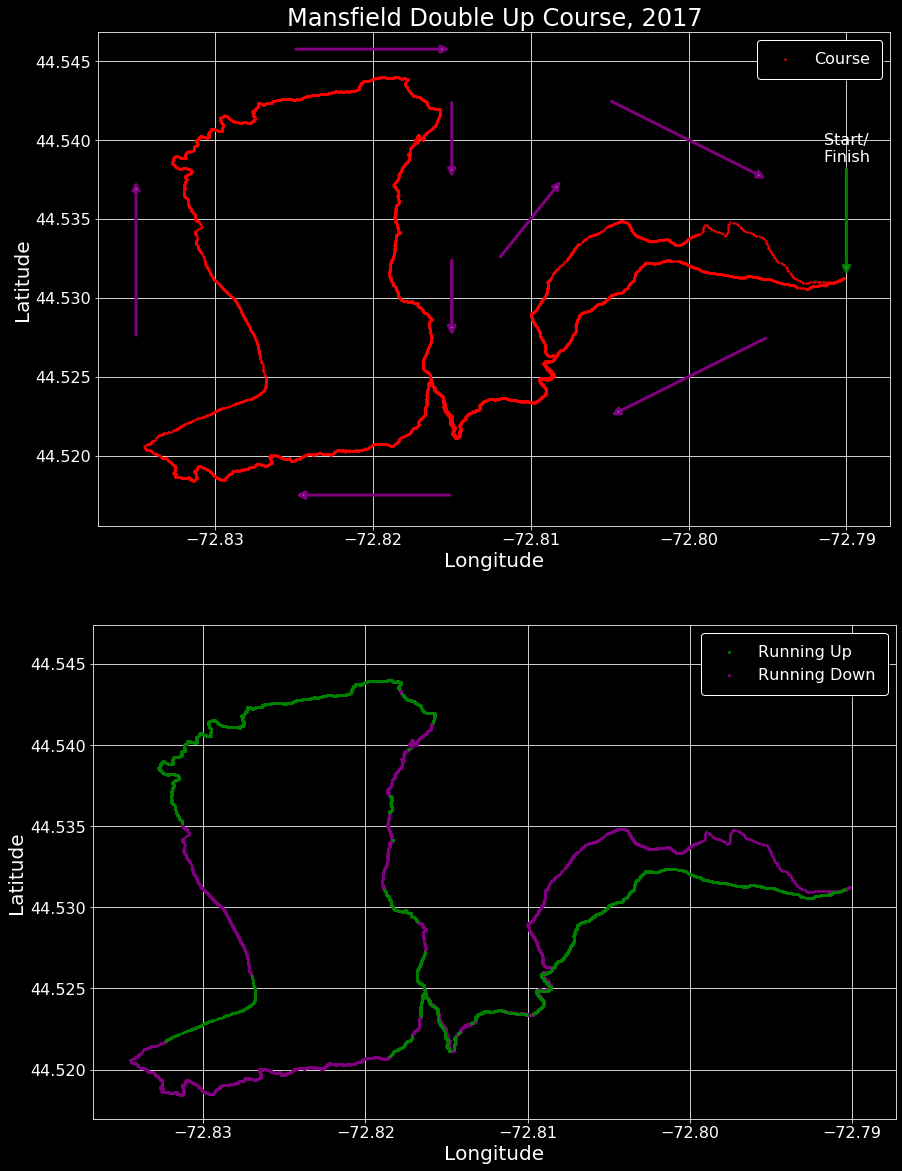

In [20]:
# Plot course lat/lon and distinguish up/down
with plt.style.context('dark_background'):   
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

    # Subplot 1
    double_up_gdf.plot(
        ax=ax1, markersize=2, color='r', zorder=2, label='Course')

    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.set_title("Mansfield Double Up Course, 2017", size=20)
    ax1.grid(True, zorder=1)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.title.set_size(24)
    ax1.tick_params(labelsize=16)
    
    ax1.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)

    # Add course direction arrows
    ax1.annotate(
        s='Start/\nFinish', 
        xy=(-72.79, double_up_df_enhance.latitude[0] + .0002),
        xytext=(-72.79, double_up_df_enhance.latitude[0] + 0.0075),
        arrowprops={
            'arrowstyle': '-|>', 
            'lw': 3, 
            'ec': 'g',
            'shrinkA': 2},
        ha='center', 
        fontsize=16)
    
    ax1.annotate(
        s='', xy=(-72.805, 44.5225), xytext=(-72.795, 44.5275),
        arrowprops={
            'arrowstyle': '-|>', 
            'lw': 3, 
            'ec': 'purple',
            'shrinkA': 2},
        ha='center', 
        fontsize=16) 

    ax1.annotate(
        s='', xy=(-72.825, 44.5175), xytext=(-72.815, 44.5175),
        arrowprops={
            'arrowstyle': '-|>', 
            'lw': 3, 
            'ec': 'purple',
            'shrinkA': 2},
        ha='center', 
        fontsize=16) 

    ax1.annotate(
        s='', xy=(-72.835, 44.5375), xytext=(-72.835, 44.5275),
        arrowprops={
            'arrowstyle': '-|>', 
            'lw': 3, 
            'ec': 'purple',
            'shrinkA': 2},
        ha='center', 
        fontsize=16) 

    ax1.annotate(
        s='', xy=(-72.815, 44.54575), xytext=(-72.825, 44.54575),
        arrowprops={
            'arrowstyle': '-|>', 
            'lw': 3, 
            'ec': 'purple',
            'shrinkA': 2},
        ha='center', 
        fontsize=16) 

    ax1.annotate(
        s='', xy=(-72.815, 44.5375), xytext=(-72.815, 44.5425), 
        arrowprops={
            'arrowstyle': '-|>', 
            'lw': 3, 
            'ec': 'purple',
            'shrinkA': 2},
        ha='center', 
        fontsize=16)

    ax1.annotate(
        s='', xy=(-72.815, 44.5275), xytext=(-72.815, 44.5325),
        arrowprops={
            'arrowstyle': '-|>', 
            'lw': 3, 
            'ec': 'purple',
            'shrinkA': 2},
        ha='center', 
        fontsize=16)
    
    ax1.annotate(
        s='', xy=(-72.815, 44.5275), xytext=(-72.815, 44.5325),
        arrowprops={
            'arrowstyle': '-|>', 
            'lw': 3, 
            'ec': 'purple',
            'shrinkA': 2},
            ha='center', 
        fontsize=16) 
    
    ax1.annotate(
        s='', xy=(-72.808, 44.5375), xytext=(-72.812, 44.5325),
        arrowprops={
            'arrowstyle': '-|>', 
            'lw': 3, 
            'ec': 'purple',
            'shrinkA': 2},
        ha='center', 
        fontsize=16)

    ax1.annotate(
        s='', xy=(-72.795, 44.5375), xytext=(-72.805, 44.5425),
        arrowprops={
            'arrowstyle': '-|>', 
            'lw': 3, 
            'ec': 'purple',
            'shrinkA': 2},
        ha='center', 
        fontsize=16) 

    
    # Subplot 2
    double_up_gdf[double_up_gdf.vertical_speed_ft_per_sec >= 0].plot(
        ax=ax2, markersize=4, color='g', label="Running Up", zorder=3)
    double_up_gdf[double_up_gdf.vertical_speed_ft_per_sec < 0].plot(
        ax=ax2, markersize=4, color='purple', label="Running Down", zorder=2) 

    ax2.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)

    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    ax2.grid(True, zorder=1)
    ax2.xaxis.label.set_size(20)
    ax2.yaxis.label.set_size(20)
    ax2.title.set_size(24)
    ax2.tick_params(labelsize=16)

    
    plt.show()

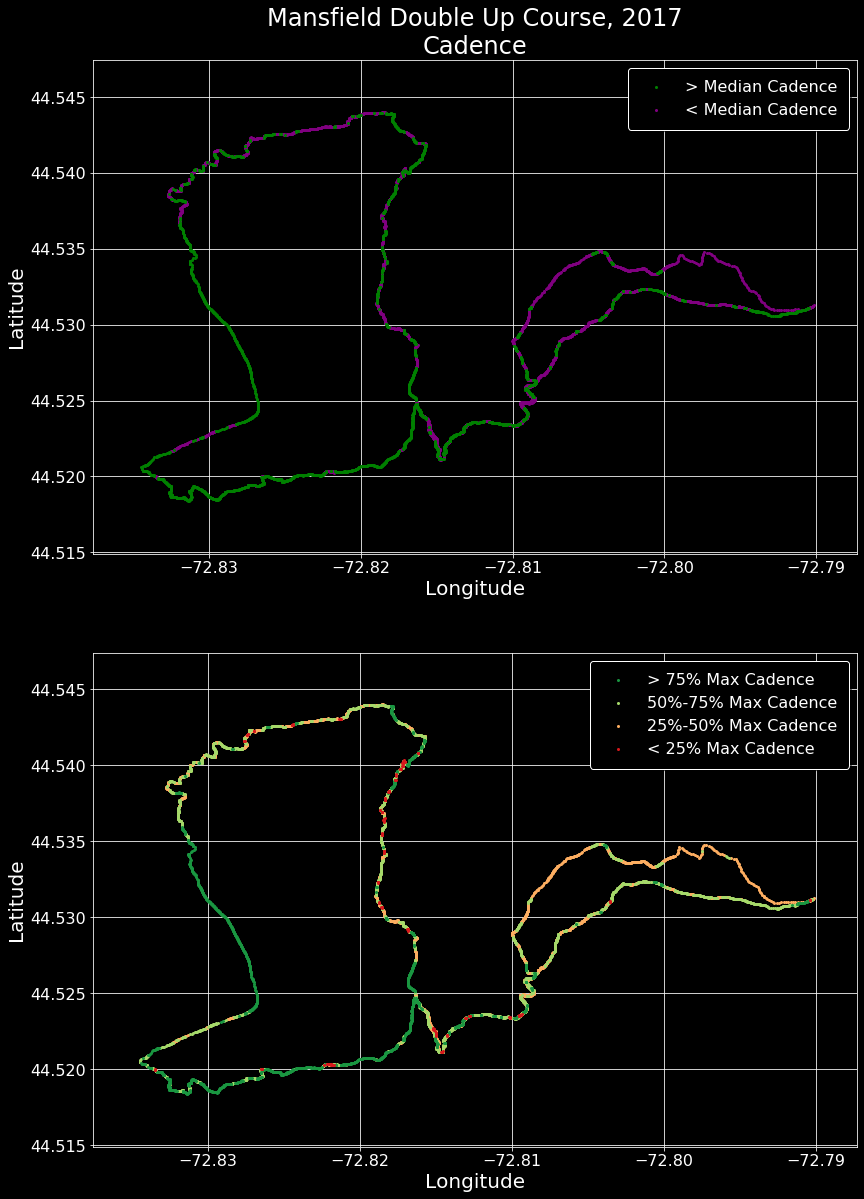

In [21]:
# Plot course lat/lon with cadence
with plt.style.context('dark_background'):  

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
    
    # Subplot 1
    double_up_gdf[double_up_gdf.cadence >= double_up_gdf.cadence.median()].plot(
        ax=ax1, markersize=4, color='g', label="> Median Cadence", zorder=3)
    double_up_gdf[double_up_df_enhance.cadence < double_up_df_enhance.cadence.median()].plot(
        ax=ax1, markersize=4, color='purple', label="< Median Cadence", zorder=2)
    
    ax1.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.set_title("Mansfield Double Up Course, 2017\nCadence", size=20)
    ax1.grid(True, zorder=1)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.title.set_size(24)
    ax1.tick_params(labelsize=16)
    
    
    # Subplot 2
    double_up_gdf[double_up_gdf.cadence >= double_up_gdf.cadence.max()*0.75].plot(
        ax=ax2, markersize=4, color='#1a9641', label="> 75% Max Cadence", zorder=5)
    double_up_gdf[(double_up_gdf.cadence < double_up_gdf.cadence.max()*0.75) & (double_up_gdf.cadence >= double_up_gdf.cadence.max()*0.5)].plot(
        ax=ax2, markersize=4, color='#a6d96a', label="50%-75% Max Cadence", zorder=4)
    double_up_gdf[(double_up_gdf.cadence < double_up_gdf.cadence.max()*0.50) & (double_up_gdf.cadence >= double_up_gdf.cadence.max()*0.25)].plot(
        ax=ax2, markersize=4, color='#fdae61', label="25%-50% Max Cadence", zorder=3)
    double_up_gdf[double_up_gdf.cadence < double_up_gdf.cadence.max()*0.25].plot(
        ax=ax2, markersize=4, color='#d7191c', label="< 25% Max Cadence", zorder=6)
    
    ax2.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    ax2.grid(True, zorder=1)
    ax2.xaxis.label.set_size(20)
    ax2.yaxis.label.set_size(20)
    ax2.title.set_size(24)
    ax2.tick_params(labelsize=16)

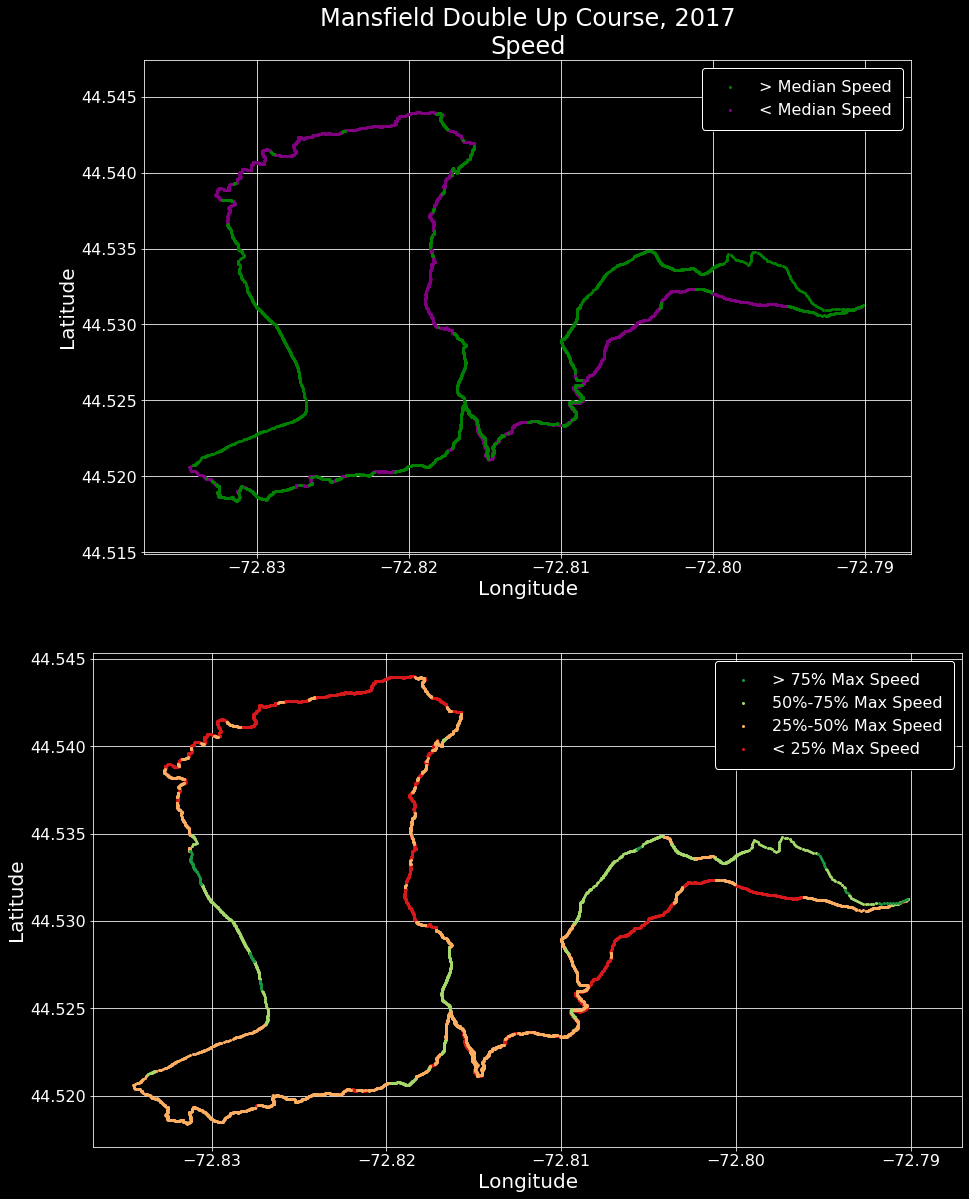

In [22]:
# Plot course lat/lon with speed
with plt.style.context('dark_background'):  

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
    
    # Subplot 1
    double_up_gdf[double_up_gdf.speed_mph >= double_up_gdf.speed_mph.median()].plot(
        ax=ax1, markersize=4, color='g', label="> Median Speed", zorder=3)
    double_up_gdf[double_up_gdf.speed_mph < double_up_gdf.speed_mph.median()].plot(
        ax=ax1, markersize=4, color='purple', label="< Median Speed", zorder=2)
    
    ax1.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.set_title("Mansfield Double Up Course, 2017\nSpeed", size=20)
    ax1.grid(True, zorder=1)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.title.set_size(24)
    ax1.tick_params(labelsize=16)
    
    
    # Subplot 2
    double_up_gdf[double_up_gdf.speed_mph >= double_up_gdf.speed_mph.max()*0.75].plot(
        ax=ax2, markersize=4, color='#1a9641', label="> 75% Max Speed", zorder=5)
    double_up_gdf[(double_up_gdf.speed_mph < double_up_gdf.speed_mph.max()*0.75) & (double_up_gdf.speed_mph >= double_up_gdf.speed_mph.max()*0.5)].plot(
        ax=ax2, markersize=4, color='#a6d96a', label="50%-75% Max Speed", zorder=4)
    double_up_gdf[(double_up_gdf.speed_mph < double_up_gdf.speed_mph.max()*0.50) & (double_up_gdf.speed_mph >= double_up_gdf.speed_mph.max()*0.25)].plot(
        ax=ax2, markersize=4, color='#fdae61', label="25%-50% Max Speed", zorder=4)
    double_up_gdf[double_up_gdf.speed_mph < double_up_gdf.speed_mph.max()*0.25].plot(
        ax=ax2, markersize=4, color='#d7191c', label="< 25% Max Speed", zorder=2)
    
    ax2.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    ax2.grid(True, zorder=1)
    ax2.xaxis.label.set_size(20)
    ax2.yaxis.label.set_size(20)
    ax2.title.set_size(24)
    ax2.tick_params(labelsize=16)
    
    plt.show()

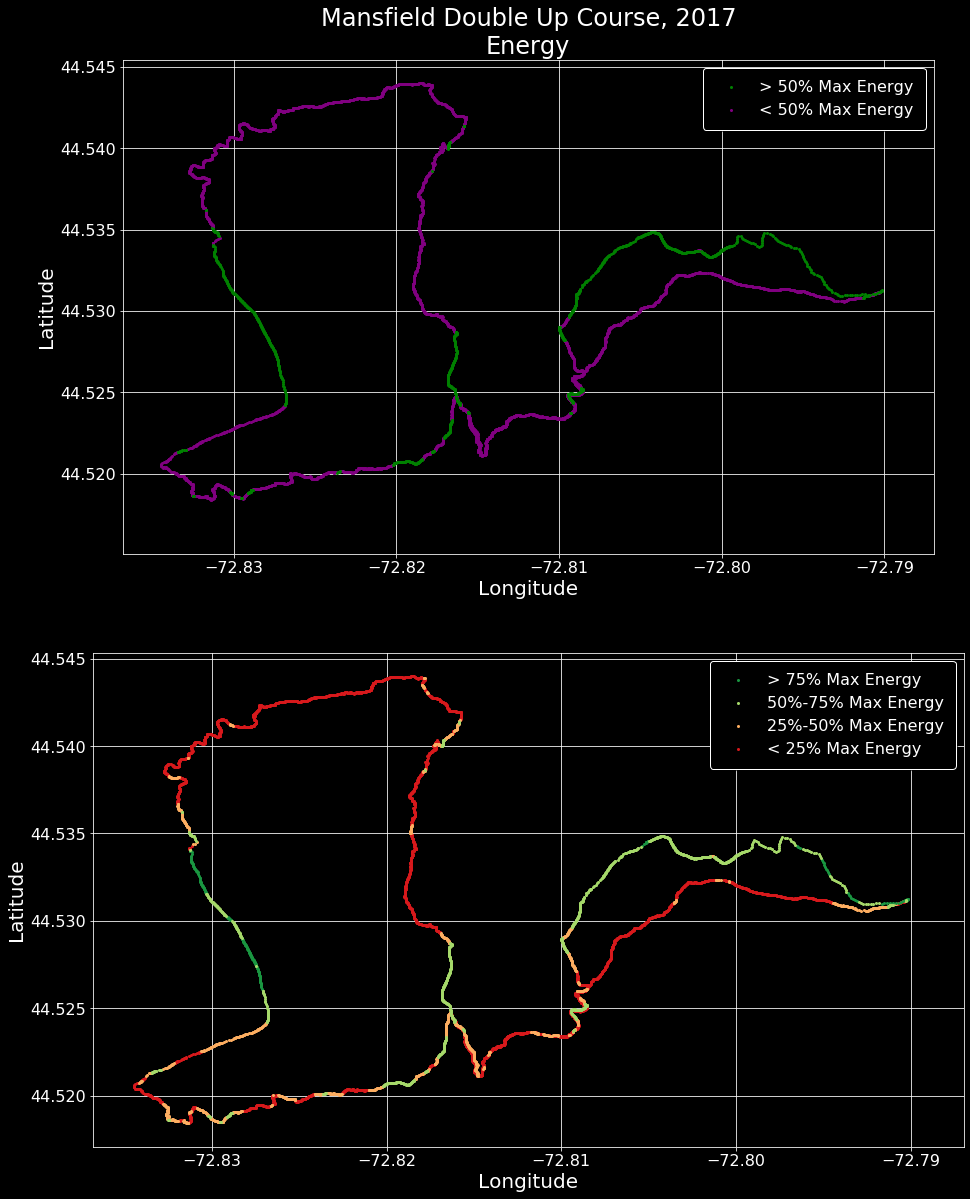

In [23]:
# Plot course lat/lon with normalized energy
with plt.style.context('dark_background'):  

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
    
    # Subplot 1
    double_up_gdf[double_up_gdf.energy_norm >= 0.5].plot(
        ax=ax1, markersize=4, color='g', label="> 50% Max Energy", zorder=3)
    double_up_gdf[double_up_gdf.energy_norm < 0.5].plot(
        ax=ax1, markersize=4, color='purple', label="< 50% Max Energy", zorder=2)
    
    ax1.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.set_title("Mansfield Double Up Course, 2017\nEnergy", size=20)
    ax1.grid(True, zorder=1)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.title.set_size(24)
    ax1.tick_params(labelsize=16)
    
    # Subplot 2
    double_up_gdf[double_up_gdf.energy_norm >= 0.75].plot(
        ax=ax2, markersize=4, color='#1a9641', label="> 75% Max Energy", zorder=5)
    double_up_gdf[(double_up_gdf.energy_norm <0.75) & (double_up_gdf.energy_norm >= 0.5)].plot(
        ax=ax2, markersize=4, color='#a6d96a', label="50%-75% Max Energy", zorder=5)
    double_up_gdf[(double_up_gdf.energy_norm <0.5) & (double_up_gdf.energy_norm >= 0.25)].plot(
        ax=ax2, markersize=4, color='#fdae61', label="25%-50% Max Energy", zorder=3)
    double_up_gdf[double_up_gdf.energy_norm <= 0.25].plot(
        ax=ax2, markersize=4, color='#d7191c', label="< 25% Max Energy", zorder=2)    
    
    ax2.legend(borderpad=0.75,
          edgecolor='white',
          fontsize=16,
          shadow=True)
    
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    ax2.grid(True, zorder=1)
    ax2.xaxis.label.set_size(20)
    ax2.yaxis.label.set_size(20)
    ax2.title.set_size(24)
    ax2.tick_params(labelsize=16)
    
    plt.show()

### 5.7 Upload Course to ArcGIS Online

This section uses functions to upload the course shapefile (created in a previous project and included in the *02-raw-data* folder) to ArcGIS Online as a feature service. The workflow then creates a map widget in the Jupyter Notebook showing the course route with a topographic basemap, which provides further locational context to the course.

In [24]:
# Connect using ArcGIS Pro connection
gis = GIS('pro') 

# Test if valid user
try:    
    assert gis.users.get(username_agol) is not None, "Invalid username"
    
# Catch assertion error
except AssertionError as error:
    print(f"AssertionError: {error}")

# Catch other exceptions
except Exception as error:
    print(f"ERROR: {error}")

else:
    # Delete existing shapefile and feature service
    delete_if_exists_on_agol(os.path.splitext(double_up_zip_path)[0],
                             username_agol, 'Shapefile')
    delete_if_exists_on_agol(os.path.splitext(double_up_zip_path)[0],
                             username_agol, 'Feature Service')

Found items for title=mount_mansfield_double_up_course, owner=cxk525_pennstate, itemType=Shapefile:
[<Item title:"mount_mansfield_double_up_course" type:Shapefile owner:cxk525_pennstate>]
Item mount_mansfield_double_up_course has been deleted.
Found items for title=mount_mansfield_double_up_course, owner=cxk525_pennstate, itemType=Feature Service:
[<Item title:"mount_mansfield_double_up_course" type:Feature Layer Collection owner:cxk525_pennstate>]
Item mount_mansfield_double_up_course has been deleted.


In [25]:
# Upload and publish zip file
try:
    # Upload zip file to AGOL
    double_up_shp_agol = gis.content.add(
        {'type': 'Shapefile'}, double_up_zip_path)
    
except Exception as error:
    print(f"ERROR: {error}")
    
else:
    # If no exceptions
    # Publish as feature service
    double_up_feature_service = double_up_shp_agol.publish()
    
    # Confirm shapefile and feature class exist on AGOL
    print("SUCCESS: Uploaded and published shapefile.")
    print(search_agol(os.path.splitext(double_up_shp_path)[0],
                  username_agol, 'Shapefile'))
    print(search_agol(os.path.splitext(double_up_shp_path)[0],
                  username_agol, 'Feature Service'))

SUCCESS: Uploaded and published shapefile.
[<Item title:"mount_mansfield_double_up_course" type:Shapefile owner:cxk525_pennstate>]
[<Item title:"mount_mansfield_double_up_course" type:Feature Layer Collection owner:cxk525_pennstate>]


In [26]:
# Optional; display feature service listing
##double_up_feature_service

In [27]:
# Create map widget, customize, and display
double_up_map = gis.map()
double_up_map.basemap = 'topo'
double_up_map.add_layer(double_up_feature_service)
double_up_map.center = [44.531858, -72.817090]
double_up_map.zoom = 13
double_up_map

MapView(layout=Layout(height='400px', width='100%'), zoom=13.0)

## 6.0 Risk Assessment

This analysis assumed that the GPX data was accurate, and the workflow did not alter or omit any data points. Any inconsistencies, uncertainty, or bias within the GPX data was carried throughout the workflow, which could have affected the data visualizations.

## 7.0 Conclusion

This analysis set out to answer the following questions: What is the nature of metrics for a runner in the Mansfield Double Up, and how do these metrics vary throughout the race? 

In parsing the GPX file and visualizing the data, this workflow produced a quantitative analysis of the latitude, longitude, elevation, cadence, distance, energy, horizontal speed, and vertical speed for a typical runner throughout completion of the Mansfield Double Up.